# Datacamp Claim Scoring solution

This notebook provided a commented solution for the datacamp exercice.

# Summary

Here are the major steps covered in this notebook, from raw data to model evaluation & interpretation:
1. __Data loading__ : Read the data from csv file into DataFrame
2. __Data preprocessing__ : Tranform the raw data so that it can be used by ML algorithm
3. __Creating basic predictive models__ : Build some standard ML model to predict the target
4. __Evaluating models__ with cross-validation : Quantitative evaluation of the models' performance and compare them
5. __Analyzing model__ with permutation importance : Analyze which variables are the most important for the model

# Data loading

Let's load the data from CSV file with `pd.read_csv` function.  
* Some of the columns are dates in text form, we use `parse_dates` parameters to tell pandas to convert them to datetime.  
* `index=0` tells pandas to use the first column as the index of the DataFrame.

In [1]:
import pandas as pd

df = pd.read_csv(
    "cleaner_dataframe.csv",
    parse_dates=[
        "Claim Incident date",
        "FE_Declaration_date",
        "Initial coverage date",
        "First claim decision date",
        "Last claim decisión date",
        "Policy Holder date of birth",
        "Age policy at claim",
    ],
    index_col=0,
)

It is always useful to have a few checks after loading the data to see how it looks like

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67770 entries, 1 to 13
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Claim Incident date            67770 non-null  datetime64[ns]
 1   FE_Declaration_date            67770 non-null  datetime64[ns]
 2   Initial coverage date          67770 non-null  datetime64[ns]
 3   First claim decision date      67770 non-null  datetime64[ns]
 4   Last claim decisión date       67750 non-null  datetime64[ns]
 5   Insured amount                 67770 non-null  float64       
 6   Initial_Instalment_Amount      67770 non-null  float64       
 7   Policy Holder date of birth    67770 non-null  datetime64[ns]
 8   Age at signature               67770 non-null  int64         
 9   Sexo                           67770 non-null  object        
 10  Refused decision reason code   17295 non-null  float64       
 11  Trad_Refusal_reaso


Now, we will split the dataset into:
* __Y__: a vector containing whether or not a claim was refused
* __X__: a matrix containing the features. For this matter, we will store the name of the features and the name of the target.

Note that we exclude the date from the features used because we created the last three columns using them.

In [3]:
feature_names = [
    "Insured amount",
    "Initial_Instalment_Amount",
    "Age at signature",
    "Sexo",
    "Age policy at claim",
    "Delay declaration",
    "Age client at claim",
]
target_names = "Refusal_Flag"
X, y = df[feature_names].copy(), df[target_names].copy()

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67770 entries, 1 to 13
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Insured amount             67770 non-null  float64
 1   Initial_Instalment_Amount  67770 non-null  float64
 2   Age at signature           67770 non-null  int64  
 3   Sexo                       67770 non-null  object 
 4   Age policy at claim        67770 non-null  object 
 5   Delay declaration          67770 non-null  object 
 6   Age client at claim        67770 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 4.1+ MB


In [5]:
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 67770 entries, 1 to 13
Series name: Refusal_Flag
Non-Null Count  Dtype 
--------------  ----- 
67770 non-null  object
dtypes: object(1)
memory usage: 1.0+ MB


# Data Preprocessing
In order to use the data with ML algorithmes: all columns must be converted/encoded in numerical values

## Convert timedelta to number

We are reusing the data that we clean during the morning of the datacamp.

Note that from the original dataset, we created three new columns:

- the age of the policy at the time of claim
- the delay of the claim
- the age of the client at the time of claim

Those columns were stored as `timedelta` (cf. [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html)) expressed in days.

In [6]:
X["Age policy at claim"].iloc[0]  # For the moment this column contains string like this

'1658 days'

We convert these 3 columns into number of days in 2 steps:
* `pd.to_timedelta` convert string into `timedelta` which is a format for diff between 2 datetimes values
* `dt.days` convert the time difference in days so its become numerical

In [7]:
X["Age policy at claim"] = pd.to_timedelta(X["Age policy at claim"]).dt.days
X["Delay declaration"] = pd.to_timedelta(X["Delay declaration"]).dt.days
X["Age client at claim"] = pd.to_timedelta(X["Age client at claim"]).dt.days

In [8]:
X["Age policy at claim"].iloc[0]  # After conversion

1658

We can check that all 3 columns are now integer

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67770 entries, 1 to 13
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Insured amount             67770 non-null  float64
 1   Initial_Instalment_Amount  67770 non-null  float64
 2   Age at signature           67770 non-null  int64  
 3   Sexo                       67770 non-null  object 
 4   Age policy at claim        67770 non-null  int64  
 5   Delay declaration          67770 non-null  int64  
 6   Age client at claim        67770 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 4.1+ MB


## Convert categorical feature to number
The remaining column "Sexo" is a categorical column in form of string, we will have to convert it to numerical before training ML models.

There are different methods to encode categories into numerical representation, but the methods will depends on which ML model is used. We will discuss each method corresponding to each ML model in the next section.

In [10]:
categorical_columns = [
    "Sexo",
]

In [11]:
# define the list of the numerical columns (the ones that are not categorical)
numerical_columns = X.columns.difference(categorical_columns).tolist()
numerical_columns

['Age at signature',
 'Age client at claim',
 'Age policy at claim',
 'Delay declaration',
 'Initial_Instalment_Amount',
 'Insured amount']

# Creating basic predictive models

Now, we can design some predictive model. Here, we will develop 3 predictive models:

- a dummy classifier that is not going to use `X` to make any prediction. It is not an interesting model but it provides a kind of baseline.
- a linear model with an adequate preprocessing. Indeed, the preprocessing has to contain a scaler and a one-hot encoder.
- a gradient boosting decision trees model. This model should use an ordinal encoder in its preproceesing stage.

Let's define the three models.



## Dummy classifier

In [12]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier()

## Linear model

We will apply LogisticRegression for this data. Logistic Regression algorithm requires the data to be prepared as following:
* Numerical variable should be "normalized" to mean=0 and variance=1. This is done by applying `StandardScaler`.
* Categorical variables should be encoded as binary (1/0) columns with OneHotEncoder.

### One-hot encoding

When using a linear model, we will be "usually" interested of having an independence between categories. Therefore, with such models, `OneHotEncoder` is an interesting encoder. We will reproduce the previous experiment to show what this encoder does.

In [13]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = encoder.fit_transform(X[categorical_columns])

In [14]:
X_train_encoded = pd.DataFrame(
    X_train_encoded, columns=encoder.get_feature_names_out()
)
X_train_encoded

,Sexo_Femme,Sexo_Homme
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0
...,...,...
67765,0.0,1.0
67766,0.0,1.0
67767,0.0,1.0
67768,0.0,1.0


We see that each category becomes a column and that an indicator 0/1 is used to indicate whether or not we deal with the category for this sample.

### Combining all the steps

Now let's build the linear model pipeline

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [16]:
preprocessor = ColumnTransformer(  # ColumnTransformer will transform columns with corresponding preprocessing step
    transformers=[
        ("categorical_processor", OneHotEncoder(), categorical_columns),  # apply OneHotEncoder to categorical columns
        ("numerical_processor", StandardScaler(), numerical_columns),  # apply StandardScaler to numerical columns
])

linear_model = Pipeline(  # Pipeline will combine steps into one chain of data processing
    steps=[
        ("preprocessor", preprocessor),  # first preprocess data
        ("classifier", LogisticRegression())  # then apply Logistic Regression
])
linear_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_processor',
                                                  OneHotEncoder(), ['Sexo']),
                                                 ('numerical_processor',
                                                  StandardScaler(),
                                                  ['Age at signature',
                                                   'Age client at claim',
                                                   'Age policy at claim',
                                                   'Delay declaration',
                                                   'Initial_Instalment_Amount',
                                                   'Insured amount'])])),
                ('classifier', LogisticRegression())])

## Tree-based model

Tree based model do not require to normalize numerical variable, and categorical variables can be used with OrdinalEncoding method.

### Ordinal encoding

The simplest encoding that we can use is to replace each category by an integer. We will therefore have categories represented by values between `[0, n_categories - 1]`. We will illustrate below such encoding:

In [17]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X[categorical_columns])
X_train_encoded

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

The output of scikit-learn will be a NumPy array. We can create a pandas `DataFrame` using the `get_feature_names_out` method to generate the column names. This method allows to track complex column transformation in scikit-learn `Pipeline` as well.

In [18]:
X_train_encoded = pd.DataFrame(
    X_train_encoded, columns=encoder.get_feature_names_out()
)
X_train_encoded

,Sexo
0,1.0
1,0.0
2,1.0
3,0.0
4,1.0
...,...
67765,1.0
67766,1.0
67767,1.0
67768,1.0


We observe that each categories is therefore encoded with an integer. We could check the correspondence by looking at the fitted attributes of the encoder.

In [19]:
for col_name, col_categories in zip(
    encoder.get_feature_names_out(),
    encoder.categories_
):
    print(f"For feature named {col_name!r}")
    print()
    for code, cat in enumerate(col_categories):
        print(f"\tCategory {cat!r} mapped to {code}")
    print()

For feature named 'Sexo'

	Category 'Femme' mapped to 0
	Category 'Homme' mapped to 1



This type of encoder is imposing an ordering and it is not always adequate for linear model in which we don't want to impose such modeling. It is therefore the encoder of choice used in tree-based models.



### Combine into model pipeline

We combine the OrdinalEncoder with a Gradient Boosting classifier to create a tree based modeling pipeline



In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier

preprocessor = ColumnTransformer(transformers=[
        ("categorical_processor", OrdinalEncoder(), categorical_columns),  # apply OrdinalEncoder to categorical columns
    ],
    remainder="passthrough",  # this means all other columns not listed above are kept as-is
)

hgbdt_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=0)),
])
hgbdt_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_processor',
                                                  OrdinalEncoder(),
                                                  ['Sexo'])])),
                ('classifier', HistGradientBoostingClassifier(random_state=0))])

# Evaluating these models with cross-validation

Now that we define these models, we have to evaluate them to find the best model for our use case.
1. Choose a metric.
2. Choose a validation strategy
3. Run cross-validation for each model, compare them

### Which metric to use?

First the target is highly imbalanced.

In [21]:
y.value_counts(normalize=True)

No     0.744799
Yes    0.255201
Name: Refusal_Flag, dtype: float64

Indeed, the proportion of `"No"` and `"Yes"` is not 50-50. We therefore need to select a proper statistical metric. Here, we can use the ROC-AUC.

We also need to choose a cross-validation strategy. A stratified k-fold cross-validation is a good choice in this case to be sure that the ratio of the classes is preserved in each of the splits. In addition, we will shuffle the data. I will come back on this point.

Let's evaluate the dummy classifier.

In [22]:
from sklearn.model_selection import cross_validate, StratifiedKFold

cv = StratifiedKFold(n_splits=30, shuffle=True)
cv_results = cross_validate(
    dummy_model, X, y,
    return_train_score=True,
    scoring=["roc_auc"],
    n_jobs=-1,
    cv=cv,
)
cv_results = pd.DataFrame(cv_results)
cv_results = cv_results[["train_roc_auc", "test_roc_auc"]]
print(
    f"""Dummy classifier results in terms of ROC-AUC:

    Training: {cv_results['train_roc_auc'].mean():.3f} +/- {cv_results['train_roc_auc'].std():.3f}
    Testing: {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}
    """
)

Dummy classifier results in terms of ROC-AUC:

    Training: 0.500 +/- 0.000
    Testing: 0.500 +/- 0.000
    


It is not a surprised that this model outputs an average AUC of 0.5 on both training and testing. Let's check if a linear model provides better statistics.

In [23]:
cv_results = cross_validate(
    linear_model, X, y,
    return_train_score=True,
    scoring=["roc_auc"],
    n_jobs=-1,
    cv=cv,
)
cv_results = pd.DataFrame(cv_results)
cv_results = cv_results[["train_roc_auc", "test_roc_auc"]]
print(
    f"""Linear model results in terms of ROC-AUC:

    Training: {cv_results['train_roc_auc'].mean():.3f} +/- {cv_results['train_roc_auc'].std():.3f}
    Testing: {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}
    """
)

Linear model results in terms of ROC-AUC:

    Training: 0.630 +/- 0.001
    Testing: 0.630 +/- 0.016
    


It seems that this is a bit better. We can also see that the model does not overfit since the results are similar on the training and testing set. Let's check the last model type of model:

In [24]:
cv_results = cross_validate(
    hgbdt_model, X, y,
    return_train_score=True,
    scoring=["roc_auc"],
    n_jobs=-1,
    cv=cv,
)
cv_results = pd.DataFrame(cv_results)
print(
    f"""HGBDT model results in terms of ROC-AUC:

    Training: {cv_results['train_roc_auc'].mean():.3f} +/- {cv_results['train_roc_auc'].std():.3f}
    Testing: {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}
    """
)

HGBDT model results in terms of ROC-AUC:

    Training: 0.762 +/- 0.004
    Testing: 0.735 +/- 0.011
    


We observe that this model is better than the previous one. we can see that there is a small overfitting since the model is performing worse on the testing set than on the training set.

### Draw ROC curve

In the thesis, the structure was broken to report the results because a single train-test split was used with shuffling. We can reproduce the ROC curve using such approach:

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=0
)

In [26]:
dummy_model.fit(X_train, y_train)
linear_model.fit(X_train, y_train)
_ = hgbdt_model.fit(X_train, y_train)

Now we can use the plotting tool from scikit-learn to plot the ROC curve

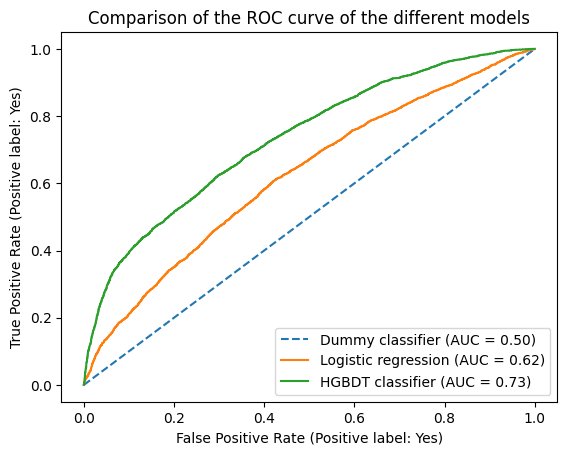

In [27]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_estimator(
    dummy_model, X_test, y_test, name="Dummy classifier", linestyle="--"
)
RocCurveDisplay.from_estimator(
    linear_model, X_test, y_test, name="Logistic regression", ax=disp.ax_
)
RocCurveDisplay.from_estimator(
    hgbdt_model, X_test, y_test, name="HGBDT classifier", ax=disp.ax_
)
_ = disp.ax_.set_title(
    "Comparison of the ROC curve of the different models"
)

As ROC AUC score is the area under the ROC curve, the tree-based model is the highest curve in the chart.

# Analyze models with Permutation importance

Permutation importance is a method to evaluate the impact of each variable on the performance of a model.

In other words, the importance score of each variable is how much the model's performance diminish if that variable get wrong values.

Here, we show how to plot the feature importances by using the permutation approach.

In [29]:
from sklearn.inspection import permutation_importance

importances = permutation_importance(
    hgbdt_model, X_test, y_test, scoring="roc_auc"
)
importances = pd.DataFrame(
    importances.importances.T,
    columns=hgbdt_model[:-1].get_feature_names_out(),
)

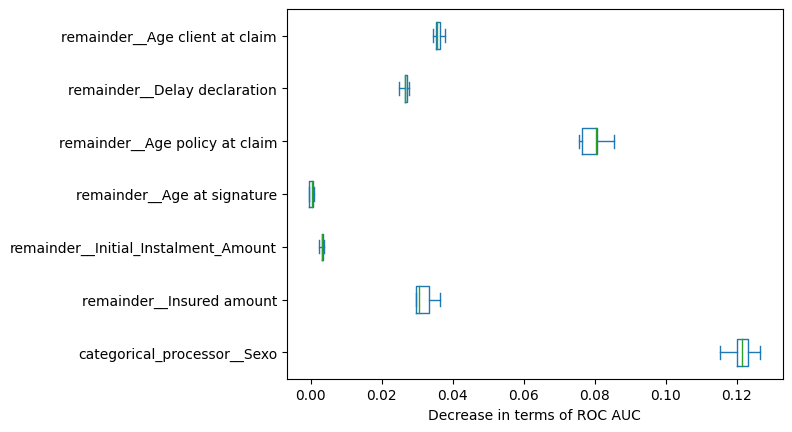

In [30]:
ax = importances.plot.box(vert=False, whis=10)
_ = ax.set_xlabel("Decrease in terms of ROC AUC")

We can see that "Sexo" and "Age policy at claim" contribute the most to the model's performance

### Conclusion

The thesis is showing the "Economic loss". We cannot construct this loss because we are missing some information. However, it comes back to assign a cost to a prediction depending if we do a mistake or not.

In the thesis, the cost depend on some external values that we don't have access. If we would have these access, we could there fore compute the cost, for all the possible threshold of used for the ROC curve and have a business oriented metric which is more maningful than the ROC curve.